# Основная часть курсовой

Датасет анекдотов: https://github.com/hemulitch/projectcorpora/tree/main

Список частеречных тегов и тегов для NER из Natasha: https://github.com/natasha/natasha?tab=readme-ov-file

## Функции и билиотеки для предобработки датасетов

In [12]:
# !pip install natasha

In [1]:
from natasha import (
    Segmenter, MorphVocab,
    NewsNERTagger,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)
import re

In [2]:
def prepare_russian_text(input_text):

    segmenter = Segmenter()
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb)
    ner_tagger = NewsNERTagger(emb)
    morph_vocab = MorphVocab()

    label_dict = {'NUM': '0', 'PRON': '1', 'PER': '2', 'LOC': '3', 'ORG': '4'}
    next_label_num = 5


    raw_text = input_text.replace('\n', ' ')
    raw_text = re.sub(r'\d+', '0' , raw_text)

    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)

    for span in reversed(doc.ner.spans):
        if span.type not in label_dict:
            label_dict[span.type] = str(next_label_num)
            next_label_num += 1
        raw_text = "".join((raw_text[:span.start], label_dict[span.type], raw_text[span.stop:]))

    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    prepared_text = ''
    prev_num = False
    for token in doc.tokens:

        if token.pos == 'NUM' and not token.text.isdigit():
            if not prev_num:
                prepared_text += '0'
                prepared_text += ' '
                prev_num = True
            continue

        prev_num = False

        if token.pos in label_dict:
            prepared_text += label_dict[token.pos]
            prepared_text += ' '

        elif token.pos != 'PUNCT':
                try:
                    token.lemmatize(morph_vocab)
                    prepared_text += token.lemma.lower()
                    prepared_text += ' '
                except Exception as ex:
                    prepared_text += token.text.lower()
                    prepared_text += ' '
    return prepared_text

## Получение датасета шуток (готовый с huggingface)
https://huggingface.co/datasets/IgorVolochay/russian_jokes/resolve/main/dataset.csv?download=true

In [3]:
import pandas as pd

In [34]:
# jokes_df = pd.read_csv('https://huggingface.co/datasets/IgorVolochay/russian_jokes/resolve/main/dataset.csv?download=true')
# # запись в файл
# jokes_df.to_csv("jokes_df.csv", index=False, encoding='utf-8')

In [12]:
jokes_df = pd.read_csv('jokes_df.csv')
print(jokes_df.shape)
jokes_df.head()

(150553, 2)


,text,words_count
0,"- Зять, а ты знаешь, где найти того мужчину, к...",22
1,"После проведения акции ""К животным по-человече...",15
2,Штирлиц пришел домой и сразу завалился на боко...,12
3,"Комету нашли русские, а захватила ее Европа. И...",13
4,"- Мальчик, какой у тебя огромный рюкзачок, что...",19


In [13]:
jokes_df['words_count'] = jokes_df['text'].apply(lambda x: len(x.split()))

In [16]:
jokes_df['words_count'].mean()

24.702530006044384

In [17]:
jokes_df['words_count'].median()

17.0

In [37]:
jokes_df.to_csv("jokes_df.csv", index=False, encoding='utf-8')

## Предобработка датасета шуток

### Подвыборка из датасета шуток

In [45]:
jokes_slice_df = jokes_df.loc[:1000]
jokes_slice_df.head()

,text,words_count
0,"- Зять, а ты знаешь, где найти того мужчину, к...",22
1,"После проведения акции ""К животным по-человече...",15
2,Штирлиц пришел домой и сразу завалился на боко...,12
3,"Комету нашли русские, а захватила ее Европа. И...",13
4,"- Мальчик, какой у тебя огромный рюкзачок, что...",19


In [46]:
from tqdm import tqdm
tqdm.pandas()

jokes_slice_df['preprocessed'] = jokes_slice_df['text'].progress_apply(lambda x: prepare_russian_text(x))

100%|██████████| 1001/1001 [16:23<00:00,  1.02it/s]
C:\Users\ttais\AppData\Local\Temp\ipykernel_2276\165010735.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jokes_slice_df['preprocessed'] = jokes_slice_df['text'].progress_apply(lambda x: prepare_russian_text(x))


In [48]:
# запись в файл
jokes_slice_df.to_csv("jokes_slice_df.csv", index=False, encoding='utf-8')

### Итеративное расширение на весь датасет шуток

In [5]:
import pandas as pd

# чтение из файла
jokes_df = pd.read_csv('jokes_df.csv')
jokes_df.head()

,text,words_count
0,"- Зять, а ты знаешь, где найти того мужчину, к...",22
1,"После проведения акции ""К животным по-человече...",15
2,Штирлиц пришел домой и сразу завалился на боко...,12
3,"Комету нашли русские, а захватила ее Европа. И...",13
4,"- Мальчик, какой у тебя огромный рюкзачок, что...",19


In [11]:
from tqdm import tqdm
tqdm.pandas()

print(jokes_df.shape)
jokes_slice_df = jokes_df.loc[116001:126000]
jokes_slice_df['preprocessed'] = jokes_slice_df['text'].progress_apply(lambda x: prepare_russian_text(x))
jokes_slice_df.to_csv('jokes_slice_df.csv', mode='a', index=False, header=False, encoding='utf-8')
jokes_slice_df = jokes_df.loc[126001:136000]
jokes_slice_df['preprocessed'] = jokes_slice_df['text'].progress_apply(lambda x: prepare_russian_text(x))
jokes_slice_df.to_csv('jokes_slice_df.csv', mode='a', index=False, header=False, encoding='utf-8')
jokes_slice_df = jokes_df.loc[136001:146000]
jokes_slice_df['preprocessed'] = jokes_slice_df['text'].progress_apply(lambda x: prepare_russian_text(x))
jokes_slice_df.to_csv('jokes_slice_df.csv', mode='a', index=False, header=False, encoding='utf-8')
jokes_slice_df = jokes_df.loc[146001:]
jokes_slice_df['preprocessed'] = jokes_slice_df['text'].progress_apply(lambda x: prepare_russian_text(x))
jokes_slice_df.to_csv('jokes_slice_df.csv', mode='a', index=False, header=False, encoding='utf-8')

(150553, 2)


100%|██████████| 10000/10000 [2:36:51<00:00,  1.06it/s] 
C:\Users\ttais\AppData\Local\Temp\ipykernel_5180\3448826754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jokes_slice_df['preprocessed'] = jokes_slice_df['text'].progress_apply(lambda x: prepare_russian_text(x))
100%|██████████| 10000/10000 [2:35:51<00:00,  1.07it/s] 
C:\Users\ttais\AppData\Local\Temp\ipykernel_5180\3448826754.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jokes_slice_df['preprocessed'] = jokes_slice_df['text'].progress_app

In [13]:
jokes_slice_df = pd.read_csv('jokes_slice_df.csv')
jokes_slice_df.shape

(150553, 3)

## Получение датасета новостей из OpenCorpora по абзацам
(корпус OpenCorpora https://opencorpora.org/ -> Скачать -> Размеченные тексты -> целиком: архив .bz2)

Теги OpenCorpora: https://opencorpora.org/dict.php?act=gram

In [34]:
# !pip install pymorphy3

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import pymorphy3

In [140]:
texts_raw_list = []
with open('annot.opcorpora.xml', 'r', encoding='utf-8') as file:
    texts_raw_list = file.readlines()
texts_raw = '\n'.join(texts_raw_list)

In [141]:
print(len(texts_raw))

491803360


In [ ]:
soup = BeautifulSoup(texts_raw, 'xml')

In [ ]:
texts = soup.find_all('text')

In [ ]:
print(len(texts))

In [ ]:
pos_label_dict = {'NUMR': '0', 'NUMB': '0', 'ROMN': '0', 'NPRO': '1'}
gram_label_dict = {'Apro': '1', 'Name': '2', 'Surn': '2', 'Patr': '2', 'Geox': '3', 'Orgn': '4', 'Trad': '4', 'Abbr': '5'}

morph = pymorphy3.MorphAnalyzer()

paragraphs_count = 0
paragraphs_meta = []
paragraphs_preprocessed = []
while paragraphs_count <= 150553:
    for text in tqdm(texts):
        for tag in text.tags:
            text_meta = text.tags.text
        for paragraph in text.paragraphs.find_all('paragraph'):
            paragraphs_meta.append(text_meta)
            paragraph_preprocessed = ''
            for sentence in paragraph.find_all('sentence'):
                for token in sentence.tokens.find_all('token'):
                    if token.l.g.get('v') in pos_label_dict:
                        paragraph_preprocessed += pos_label_dict[token.l.g.get('v')]
                        paragraph_preprocessed += ' '
                    else:
                        for gram in token.l.find_all('g'):
                            if gram.get('v') in gram_label_dict:
                                paragraph_preprocessed += gram_label_dict[gram.get('v')]
                                paragraph_preprocessed += ' '
                                break
                        else:
                            if token.l.g.get('v') == 'VERB' or token.l.g.get('v') == 'PRTF' \
                            or token.l.g.get('v') == 'PRTS' or token.l.g.get('v') == 'GRND' \
                            or token.l.g.get('v') == 'COMP' or token.l.g.get('v') == 'ADJS':
                                paragraph_preprocessed += morph.parse(token.l.get('t'))[0].normal_form
                                paragraph_preprocessed += ' '
                            elif token.l.g.get('v') != 'PNCT':
                                paragraph_preprocessed += token.l.get('t')
                                paragraph_preprocessed += ' '
                paragraph_preprocessed += '\n'
            if len(str(paragraph_preprocessed).split()) > 1:
                paragraphs_preprocessed.append(paragraph_preprocessed)
                paragraphs_count += 1

In [ ]:
len(paragraphs_preprocessed), len(paragraphs_meta)

In [ ]:
data = []
for paragraph_preprocessed, paragraph_meta in zip(paragraphs_preprocessed, paragraphs_meta):
    data.append([paragraph_preprocessed.strip(), paragraph_meta.strip()])

In [ ]:
news_preprocessed_df = pd.DataFrame(data, columns=['paragraphs_preprocessed', 'paragraphs_meta'])

In [10]:
# ~количество уникальных текстов, из которых взяты абзацы
news_preprocessed_df.paragraphs_meta.nunique()

3321

In [11]:
news_preprocessed_df['words_count'] = news_preprocessed_df['paragraphs_preprocessed'].apply(lambda x: len(str(x).split()))

In [12]:
news_preprocessed_df['words_count'].mean()

42.887546666666665

In [13]:
news_preprocessed_df['words_count'].median()

32.0

In [14]:
news_preprocessed_df = news_preprocessed_df.rename(columns={'paragraphs_preprocessed': 'preprocessed'})

In [15]:
news_preprocessed_df.head()

,preprocessed,paragraphs_meta,words_count
0,школа злословие учить прикусить язык \nсохрани...,Год:2008\nДата:25/08\nАвтор:Валентин Колеснико...,12
1,великолепный школа злословие вернуться в эфир ...,Год:2008\nДата:25/08\nАвтор:Валентин Колеснико...,51
2,писательница 2 2 и сценаристка 2 2 вроде бы не...,Год:2008\nДата:25/08\nАвтор:Валентин Колеснико...,18
3,впрочем на канал культура в роль телеведущие в...,Год:2008\nДата:25/08\nАвтор:Валентин Колеснико...,35
4,в 1 школа злословие представлять 1 интервью ве...,Год:2008\nДата:25/08\nАвтор:Валентин Колеснико...,47


In [16]:
# запись в файл
news_preprocessed_df.to_csv("news_preprocessed_df.csv", index=False, encoding='utf-8')

In [2]:
# чтение из файла
news_preprocessed_df = pd.read_csv('news_preprocessed_df.csv')
news_preprocessed_df.shape

(187500, 3)

### Получение датасета новостей по предложениям

In [10]:
sents_list = []
for paragraph in news_preprocessed_df['preprocessed']:
    sents = paragraph.split('\n')
    for sent in sents:
        if len(str(sent).split()) > 1:
            sents_list.append(sent)

In [13]:
news_sents_preprocessed_df = pd.DataFrame(sents_list, columns=['preprocessed'])
news_sents_preprocessed_df['words_count'] = news_sents_preprocessed_df['preprocessed'].apply(lambda x: len(str(x).split()))
print(f"mean: {news_sents_preprocessed_df['words_count'].mean()}")
print(f"median: {news_sents_preprocessed_df['words_count'].median()}")

mean: 14.911335078048147
median: 13.0


In [34]:
news_sents_preprocessed_df.head(5)

,preprocessed,words_count
0,5 5 2,3
1,после 1 госпожа фон ратлеф писать всё редкий и...,20
2,1 противостоять друг друг в время президентски...,12
3,в начало студент знакомиться с применение комп...,12
4,1 нет,2


In [25]:
news_sents_preprocessed_df = news_sents_preprocessed_df.sample(150553, random_state=42)
# запись в файл
news_sents_preprocessed_df.to_csv('news_sents_preprocessed_df.csv', index=False, encoding='utf-8')

In [26]:
# чтение из файла
news_sents_preprocessed_df = pd.read_csv('news_sents_preprocessed_df.csv')
news_sents_preprocessed_df.shape

(150553, 2)

## Получение датасета твитов
https://www.kaggle.com/datasets/maximsuvorov/rutweetcorp?select=twitter_corpus.csv

In [3]:
import pandas as pd
import re

In [4]:
tweets_df = pd.read_csv('twitter_corpus.csv.zip', compression='zip', lineterminator='\n')

In [5]:
print(tweets_df.shape)
tweets_df.head()

(17639669, 1)


,text
0,Пропавшая в Хабаровске школьница почти сутки п...
1,"ЛЕНТА, Я СЕГОДНЯ ПОЛГОДА ДИРЕКШИОНЕЕЕЕР! С:\nХ..."
2,Царствие Божие внутрь вас есть.
3,RT @TwitRegion: Ученые: кофе приносит намного ...
4,http://t.co/ZzzwYLSmon справка по адаптации 5 ...


In [6]:
tweets_df['words_count'] = tweets_df['text'].apply(lambda x: len(str(x).split()))

In [9]:
tweets_df['words_count'].mean()

9.655676588942796

In [21]:
print(tweets_df.shape)
tweets_df = tweets_df[tweets_df['words_count'] >= 23]
tweets_df.shape

(17639669, 2)


(380917, 2)

In [22]:
tweets_df['words_count'].mean()

24.36486163652449

In [23]:
tweets_df['words_count'].median()

24.0

In [24]:
tweets_df.to_csv('tweets_23words_or_longer.csv', index=False, encoding='utf-8')

In [25]:
tweets_df = pd.read_csv('tweets_23words_or_longer.csv')

(array([5.9005e+04, 0.0000e+00, 3.8991e+04, 0.0000e+00, 2.4723e+04,
        0.0000e+00, 1.3389e+04, 0.0000e+00, 7.3070e+03, 0.0000e+00,
        3.5410e+03, 0.0000e+00, 1.6570e+03, 0.0000e+00, 0.0000e+00,
        7.6900e+02, 0.0000e+00, 3.2700e+02, 0.0000e+00, 2.3600e+02,
        0.0000e+00, 1.1800e+02, 0.0000e+00, 2.4000e+01, 0.0000e+00,
        4.6000e+01, 0.0000e+00, 3.2000e+01, 0.0000e+00, 0.0000e+00,
        1.3000e+01, 0.0000e+00, 1.4000e+01, 0.0000e+00, 3.1000e+01,
        0.0000e+00, 2.7000e+01, 0.0000e+00, 1.7000e+01, 0.0000e+00,
        9.0000e+00, 0.0000e+00, 1.2000e+01, 0.0000e+00, 0.0000e+00,
        1.8000e+01, 0.0000e+00, 1.0000e+01, 0.0000e+00, 7.0000e+00,
        0.0000e+00, 6.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        2.2000e+01, 0.0000e+00, 2.1000e+01, 0.0000e+00, 0.0000e+00,
        1.3000e+01, 0.0000e+00, 4.0000e+00, 0.0000e+00, 8.0000e+00,
        0.0000e+00, 1.0000e+01, 0.0000e+00, 9.0000e+00, 0.0000e+00,
        7.0000e+00, 0.0000e+00, 5.0000e+00, 0.00

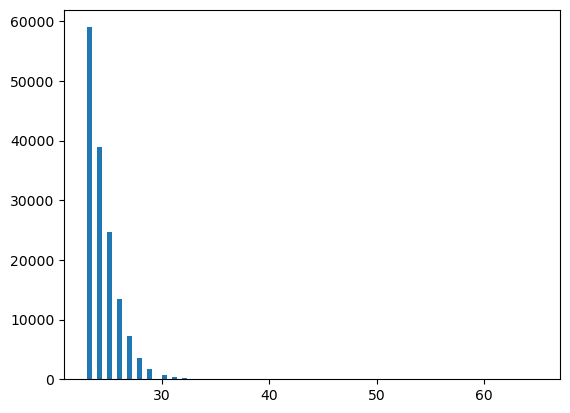

In [20]:
plt.hist(tweets_slice_df['words_count'], bins=90)

In [26]:
from tqdm import tqdm
tqdm.pandas()

tweets_df['prepared'] = tweets_df['text'].progress_apply(lambda x: re.sub('(@[A-za-z0-9:]+)|(RT)|(http[A-za-z0-9:\/\.]+)', '', x))

100%|██████████| 380917/380917 [00:03<00:00, 99590.02it/s] 


In [27]:
tweets_df.head()

,text,words_count,prepared
0,RT @v1ka_si: Меня удивляют эти маленькие девоч...,23,Меня удивляют эти маленькие девочки которые ...
1,"RT @digger2912: ""Кто то в углу сидит и погибае...",26,"""Кто то в углу сидит и погибает от голода, а..."
2,"А еще, а еще, на вчерашней вокальной тренировк...",24,"А еще, а еще, на вчерашней вокальной тренировк..."
3,RT @Bewit_ru: В фильмах по утрам у всех есть в...,25,В фильмах по утрам у всех есть время принять...
4,RT @5umm: Мне предстоит прожить в будущем всю ...,23,Мне предстоит прожить в будущем всю оставшую...


In [28]:
tweets_df.to_csv('tweets_23words_or_longer_prepared.csv', index=False, encoding='utf-8')

In [35]:
tweets_slice_df = tweets_df.sample(150553, random_state=42)
tweets_slice_df.to_csv('tweets_23words_or_longer_slice_prepared.csv', index=False, encoding='utf-8')

In [36]:
tweets_slice_df.shape

(150553, 3)

## Предобработка датасета твитов

In [4]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [38]:
# чтение из файла
tweets_slice_df = pd.read_csv('tweets_23words_or_longer_slice_prepared.csv')
tweets_slice_df.head()

,text,words_count,prepared
0,RT @losevmn: Во время блокады в Ленинграде ни ...,25,Во время блокады в Ленинграде ни умер НИ ОДИ...
1,от имени начальника гу мвд россии по пермскому...,24,от имени начальника гу мвд россии по пермскому...
2,"Такое ощущение, что я плачу репетитору за то, ...",23,"Такое ощущение, что я плачу репетитору за то, ..."
3,Ко всем не всегда тактичным молодым политикам ...,25,Ко всем не всегда тактичным молодым политикам ...
4,"RT @SugarVodonaeva: ""И пусть мы засыпаем в раз...",26,"""И пусть мы засыпаем в разных кроватях - гла..."


In [39]:
tweets_preprocessed_df = tweets_slice_df.loc[:10]
tweets_preprocessed_df['preprocessed'] = tweets_preprocessed_df['prepared'].progress_apply(lambda x: prepare_russian_text(x))

100%|██████████| 11/11 [00:10<00:00,  1.04it/s]
C:\Users\ttais\AppData\Local\Temp\ipykernel_7752\4140750299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_preprocessed_df['preprocessed'] = tweets_preprocessed_df['prepared'].progress_apply(lambda x: prepare_russian_text(x))


In [40]:
# запись в файл
tweets_preprocessed_df.to_csv("tweets_preprocessed_df.csv", index=False, encoding='utf-8')

### Итеративное расширение на весь датасет твитов (обрезанный под размер датасета шуток)

In [5]:
# чтение из файла
tweets_slice_df = pd.read_csv('tweets_23words_or_longer_slice_prepared.csv')

In [13]:
print(tweets_slice_df.shape)
tweets_preprocessed_df = tweets_slice_df.loc[133001:]
tweets_preprocessed_df['preprocessed'] = tweets_preprocessed_df['prepared'].progress_apply(lambda x: prepare_russian_text(x))
tweets_preprocessed_df.to_csv('tweets_preprocessed_df.csv', mode='a', index=False, header=False, encoding='utf-8')

(150553, 3)


100%|██████████| 17552/17552 [6:44:40<00:00,  1.38s/it]   
C:\Users\ttais\AppData\Local\Temp\ipykernel_12576\1776679022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_preprocessed_df['preprocessed'] = tweets_preprocessed_df['prepared'].progress_apply(lambda x: prepare_russian_text(x))


In [14]:
tweets_preprocessed_df = pd.read_csv('tweets_preprocessed_df.csv')
print(tweets_preprocessed_df.shape)
tweets_preprocessed_df.head()

(150553, 4)


,text,words_count,prepared,preprocessed
0,RT @losevmn: Во время блокады в Ленинграде ни ...,25,Во время блокады в Ленинграде ни умер НИ ОДИ...,в время блокада в 0 ни умереть ни 1 партийный ...
1,от имени начальника гу мвд россии по пермскому...,24,от имени начальника гу мвд россии по пермскому...,от имя начальник гу мвд россия по пермский кра...
2,"Такое ощущение, что я плачу репетитору за то, ...",23,"Такое ощущение, что я плачу репетитору за то, ...",такой ощущение что 1 плакать репетитор за 1 чт...
3,Ко всем не всегда тактичным молодым политикам ...,25,Ко всем не всегда тактичным молодым политикам ...,к весь не всегда 0 молодой политик оставить в ...
4,"RT @SugarVodonaeva: ""И пусть мы засыпаем в раз...",26,"""И пусть мы засыпаем в разных кроватях - гла...",и пусть 1 засыпать в разный кровать главный чт...


## Предобученные fasttext для русского

**Fasttext документация** https://fasttext.cc/docs/en/python-module.html

**Предобученные fasttext модели** https://fasttext.cc/docs/en/crawl-vectors.html

In [18]:
import io
import fasttext.util

In [19]:
def save_dictionary(fname, dictionary, args):
    length, dimension = args
    fin = io.open(fname, 'w', encoding='utf-8')
    fin.write('%d %d\n' % (length, dimension))
    for word in dictionary:
        fin.write('%s %s\n' % (word, ' '.join(map(str, dictionary[word]))))
        
def load_dictionary(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    length, dimension = map(int, fin.readline().split())
    dictionary = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        dictionary[tokens[0]] = map(float, tokens[1:])
    return dictionary

In [20]:
fasttext.util.download_model('ru', if_exists='ignore')

'cc.ru.300.bin'

In [21]:
model = fasttext.load_model('cc.ru.300.bin')

## Подсчёт Евклидовых расстояний, дисперсии и максимального расстояния абзацев новостей, твитов и анекдотов на основе векторов fasttext

In [118]:
# !pip install seaborn

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wilcoxon
from tqdm import tqdm
tqdm.pandas()

In [23]:
def text_euclidian_distances(text):
    text_list = str(text).split()
    text_euclidian_dist_vec = np.zeros(len(text_list) - 1)
    for i in range(1, len(text_list)):
        text_euclidian_dist_vec[i - 1] = np.linalg.norm(model[text_list[i]] - model[text_list[i - 1]])
    return text_euclidian_dist_vec

def text_distances_variation(text):
    text_dist = text_euclidian_distances(text)
    if np.any(text_dist):
        return np.var(text_dist)
    else:
        return None

def text_distances_max(text):
    text_dist = text_euclidian_distances(text)
    if np.any(text_dist):
        return np.max(text_dist)
    else:
        return None

In [20]:
tweets_slice_df = pd.read_csv('tweets_preprocessed_df.csv')
tweets_slice_df["variation"] = tweets_slice_df["preprocessed"].progress_apply(text_distances_variation)
tweets_slice_df["max_dist"] = tweets_slice_df["preprocessed"].progress_apply(text_distances_max)

jokes_slice_df = pd.read_csv('jokes_slice_df.csv')
jokes_slice_df["variation"] = jokes_slice_df["preprocessed"].progress_apply(text_distances_variation)
jokes_slice_df["max_dist"] = jokes_slice_df["preprocessed"].progress_apply(text_distances_max)

100%|██████████| 150553/150553 [05:52<00:00, 427.10it/s]


In [7]:
news_paragraphs_slice_df = pd.read_csv('news_preprocessed_df.csv')
news_paragraphs_slice_df["variation"] = news_paragraphs_slice_df["preprocessed"].progress_apply(text_distances_variation)
news_paragraphs_slice_df["max_dist"] = news_paragraphs_slice_df["preprocessed"].progress_apply(text_distances_max)

100%|██████████| 187500/187500 [02:54<00:00, 1074.86it/s]


In [35]:
news_sents_slice_df = pd.read_csv('news_sents_preprocessed_df.csv')
news_sents_slice_df["variation"] = news_sents_slice_df["preprocessed"].progress_apply(text_distances_variation)
news_sents_slice_df["max_dist"] = news_sents_slice_df["preprocessed"].progress_apply(text_distances_max)

100%|██████████| 150553/150553 [02:05<00:00, 1200.59it/s]


In [48]:
tweets_slice_df = tweets_slice_df.dropna(how='any',axis=0) 
tweets_slice_df = tweets_slice_df.sample(150348)
print(tweets_slice_df.shape)
tweets_slice_df.to_csv('tweets_statistics.csv', index=False, encoding='utf-8')

(150348, 6)


In [47]:
jokes_slice_df = jokes_slice_df.dropna(how='any',axis=0)
jokes_slice_df = jokes_slice_df.sample(150348)
print(jokes_slice_df.shape)
jokes_slice_df.to_csv('jokes_statistics.csv', index=False, encoding='utf-8')

(150348, 5)


In [49]:
news_paragraphs_slice_df = news_paragraphs_slice_df.dropna(subset=['variation'])
news_paragraphs_slice_df = news_paragraphs_slice_df.sample(150348)
print(news_paragraphs_slice_df.shape)
news_paragraphs_slice_df.to_csv('news_paragraphs_statistics.csv', index=False, encoding='utf-8')

(150348, 5)


In [50]:
news_sents_slice_df = news_sents_slice_df.dropna(how='any',axis=0)
print(news_sents_slice_df.shape)
news_sents_slice_df.to_csv('news_sents_statistics.csv', index=False, encoding='utf-8')

(150348, 4)


In [75]:
jokes_slice_df = pd.read_csv('jokes_statistics.csv')
tweets_slice_df = pd.read_csv('tweets_statistics.csv')
news_paragraphs_slice_df = pd.read_csv('news_paragraphs_statistics.csv')
news_sents_slice_df = pd.read_csv('news_sents_statistics.csv')

In [52]:
def bootstrap(data, stat_function, iter_count=10000):
    bootstrap_stats = []
    for i in tqdm(range(iter_count)):
        sample = np.random.choice(data, size=len(data), replace=True)
        stat = stat_function(sample)
        bootstrap_stats.append(stat)
    return np.array(bootstrap_stats)

## Дисперсия абзацев новостей, твитов и анекдотов на основе векторов fasttext

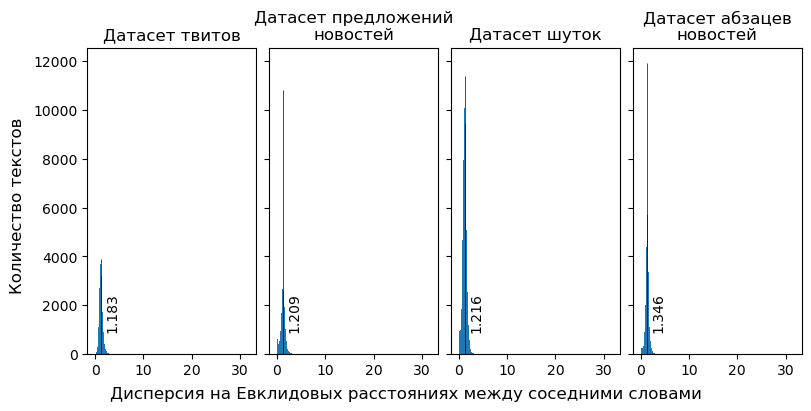

In [113]:
# Дисперсия

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex='all', sharey='all', constrained_layout=True, figsize=(8, 4))

ax1.hist(tweets_slice_df['variation'], bins=500)
# ax1.set_yscale('log')
ymin, ymax = ax1.get_ylim()
tweets_var_median = tweets_slice_df['variation'].median()
ax1.vlines(x = tweets_var_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax1.text(2.2, 1000, str(round(tweets_var_median, 3)), color='black', rotation=90)
ax1.set_title('Датасет твитов')

ax2.hist(news_sents_slice_df['variation'], bins=500)
# ax2.set_yscale('log')
ymin, ymax = ax2.get_ylim()
news_sents_var_median = news_sents_slice_df['variation'].median()
ax2.vlines(x = news_sents_var_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax2.text(2.2, 1000, str(round(news_sents_var_median, 3)), color='black', rotation=90)
ax2.set_title('Датасет предложений\nновостей')

ax3.hist(jokes_slice_df['variation'], bins=500)
# ax3.set_yscale('log')
ymin, ymax = ax3.get_ylim()
jokes_var_median = jokes_slice_df['variation'].median()
ax3.vlines(x = jokes_var_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax3.text(2.2, 1000, str(round(jokes_var_median, 3)), color='black', rotation=90)
ax3.set_title('Датасет шуток')

ax4.hist(news_paragraphs_slice_df['variation'], bins=500)
# ax4.set_yscale('log')
ymin, ymax = ax4.get_ylim()
news_paragraphs_var_median = news_paragraphs_slice_df['variation'].median()
ax4.vlines(x = news_paragraphs_var_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax4.text(2.2, 1000, str(round(news_paragraphs_var_median, 3)), color='black', rotation=90)
ax4.set_title('Датасет абзацев\nновостей')

fig.supxlabel('Дисперсия на Евклидовых расстояниях между соседними словами')
fig.supylabel('Количество текстов')

plt.show()

In [107]:
# Дисперсия

jokes_var = jokes_slice_df.variation.values
news_sents_var = news_sents_slice_df.variation.values
news_paragraphs_var = news_paragraphs_slice_df.variation.values

print("Тест Колмогорова-Смирнова на нормальность распределения. Отвергаемая нулевая гипотеза: что данные соответствуют нормальному распределению.")
print(f"Дисперсия шуток, p-value={stats.kstest(jokes_var, 'norm')[1]}")
print(f"Дисперсия предложений новостей, p-value={stats.kstest(news_sents_var, 'norm')[1]}")
print(f"Дисперсия абзацев новостей, p-value={stats.kstest(news_paragraphs_var, 'norm')[1]}")

print("\nНепараметрический критерий Вилкоксона")
print(f"- шутки vs. предложения новостей, p-value={wilcoxon(jokes_var, news_sents_var)[1]}")
print(f"- шутки vs. абзацы новостей, p-value={wilcoxon(jokes_var, news_paragraphs_var)[1]}")
print(f"- предложения новостей vs. абзацы новостей, p-value={wilcoxon(news_sents_var, news_paragraphs_var)[1]}")

Тест Колмогорова-Смирнова на нормальность распределения. Отвергаемая нулевая гипотеза: что данные соответствуют нормальному распределению.
Дисперсия шуток, p-value=0.0
Дисперсия предложений новостей, p-value=0.0
Дисперсия абзацев новостей, p-value=0.0

Непараметрический критерий Вилкоксона
- шутки vs. предложения новостей, p-value=1.60474086816886e-162
- шутки vs. абзацы новостей, p-value=0.0
- предложения новостей vs. абзацы новостей, p-value=0.0


In [108]:
jokes_bootstrap_var_median = bootstrap(jokes_var, stat_function=np.median)
confint_lower, confint_upper = np.percentile(jokes_bootstrap_var_median, [2.5, 97.5])
print(f"95% confidence interval: ({confint_lower:.5f}, {confint_upper:.5f})")

100%|██████████| 10000/10000 [00:59<00:00, 167.20it/s]

95% confidence interval: (1.21307, 1.21798)


In [109]:
news_sents_bootstrap_var_median = bootstrap(news_sents_var, stat_function=np.median)
confint_lower, confint_upper = np.percentile(news_sents_bootstrap_var_median, [2.5, 97.5])
print(f"95% confidence interval: ({confint_lower:.5f}, {confint_upper:.5f})")

100%|██████████| 10000/10000 [00:59<00:00, 168.32it/s]


95% confidence interval: (1.20524, 1.21157)


In [110]:
news_paragraphs_bootstrap_var_median = bootstrap(news_paragraphs_var, stat_function=np.median)
confint_lower, confint_upper = np.percentile(news_paragraphs_bootstrap_var_median, [2.5, 97.5])
print(f"95% confidence interval: ({confint_lower:.5f}, {confint_upper:.5f})")

100%|██████████| 10000/10000 [01:00<00:00, 164.21it/s]

95% confidence interval: (1.34364, 1.34747)


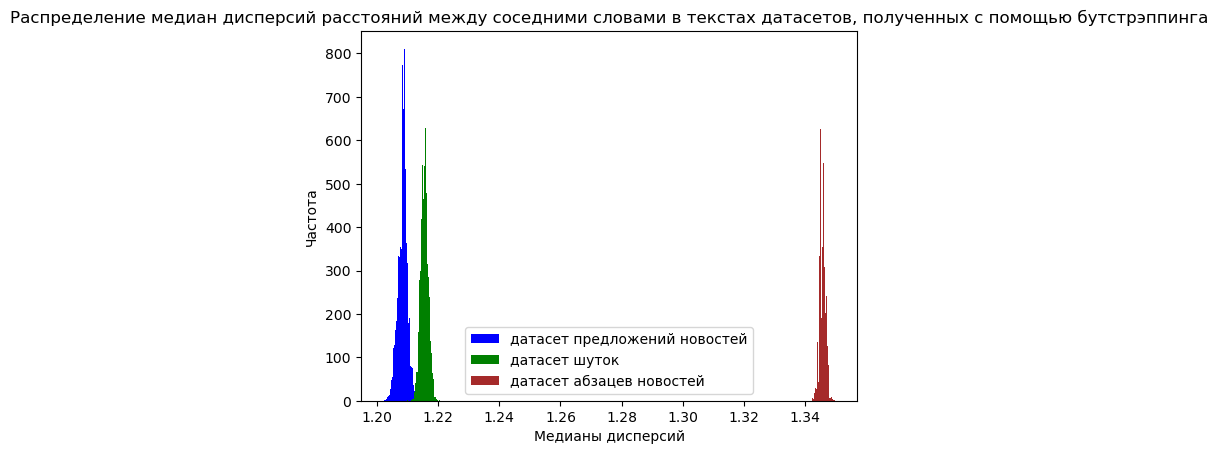

In [114]:
plt.hist(news_sents_bootstrap_var_median, label='датасет предложений новостей', bins=60, color='blue')
plt.hist(jokes_bootstrap_var_median, label='датасет шуток', bins=60, color='green')
plt.hist(news_paragraphs_bootstrap_var_median, label='датасет абзацев новостей', bins=60, color='brown')
plt.legend()

plt.title('Распределение медиан дисперсий расстояний между соседними словами в текстах датасетов, полученных с помощью бутстрэппинга')
plt.xlabel('Медианы дисперсий')
plt.ylabel('Частота')

plt.show()

## Максимум расстояний абзацев новостей, твитов и анекдотов на основе векторов fasttext

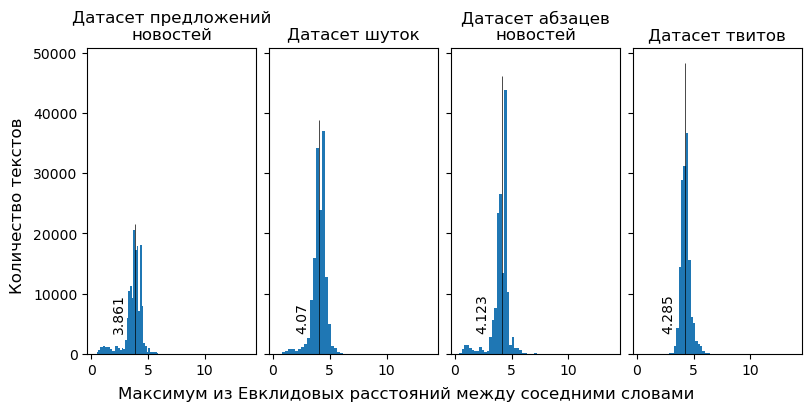

In [115]:
# Максимум

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex='all', sharey='all', constrained_layout=True, figsize=(8, 4))

ax1.hist(news_sents_slice_df['max_dist'], bins=50)
ymin, ymax = ax1.get_ylim()
news_sents_max_dist_median = news_sents_slice_df['max_dist'].median()
ax1.vlines(x = news_sents_max_dist_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax1.text(1.8, 4000, str(round(news_sents_max_dist_median, 3)), color='black', rotation=90)
ax1.set_title('Датасет предложений\nновостей')

ax2.hist(jokes_slice_df['max_dist'], bins=50)
ymin, ymax = ax2.get_ylim()
jokes_max_dist_median = jokes_slice_df['max_dist'].median()
ax2.vlines(x = jokes_max_dist_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax2.text(2.0, 4000, str(round(jokes_max_dist_median, 3)), color='black', rotation=90)
ax2.set_title('Датасет шуток')

ax3.hist(news_paragraphs_slice_df['max_dist'], bins=50)
ymin, ymax = ax3.get_ylim()
news_paragraphs_max_dist_median = news_paragraphs_slice_df['max_dist'].median()
ax3.vlines(x = news_paragraphs_max_dist_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax3.text(1.8, 4000, str(round(news_paragraphs_max_dist_median, 3)), color='black', rotation=90)
ax3.set_title('Датасет абзацев\nновостей')

ax4.hist(tweets_slice_df['max_dist'], bins=50)
ymin, ymax = ax4.get_ylim()
tweets_max_dist_median = tweets_slice_df['max_dist'].median()
ax4.vlines(x = tweets_max_dist_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax4.text(2.2, 4000, str(round(tweets_max_dist_median, 3)), color='black', rotation=90)
ax4.set_title('Датасет твитов')

fig.supxlabel('Максимум из Евклидовых расстояний между соседними словами')
fig.supylabel('Количество текстов')

plt.show()

In [65]:
# Максимум

jokes_max_dist = jokes_slice_df.max_dist.values
news_sents_max_dist = news_sents_slice_df.max_dist.values
news_paragraphs_max_dist = news_paragraphs_slice_df.max_dist.values

print("Тест Колмогорова-Смирнова на нормальность распределения. Отвергаемая нулевая гипотеза: что данные соответствуют нормальному распределению.")
print(f"Максимум из Евклидовых расстояний шуток, p-value={stats.kstest(jokes_max_dist, 'norm')[1]}")
print(f"Максимум из Евклидовых расстояний предложений новостей, p-value={stats.kstest(news_sents_max_dist, 'norm')[1]}")
print(f"Максимум из Евклидовых расстояний абзацев новостей, p-value={stats.kstest(news_paragraphs_max_dist, 'norm')[1]}")

print("\nНепараметрический критерий Вилкоксона")
print(f"- шутки vs. предложения новостей, p-value={wilcoxon(jokes_max_dist, news_sents_max_dist)[1]}")
print(f"- шутки vs. абзацы новостей, p-value={wilcoxon(jokes_max_dist, news_paragraphs_max_dist)[1]}")
print(f"- предложения новостей vs. абзацы новостей, p-value={wilcoxon(news_sents_max_dist, news_paragraphs_max_dist)[1]}")

Тест Колмогорова-Смирнова на нормальность распределения. Отвергаемая нулевая гипотеза: что данные соответствуют нормальному распределению.
Максимум из Евклидовых расстояний шуток, p-value=0.0
Максимум из Евклидовых расстояний предложений новостей, p-value=0.0
Максимум из Евклидовых расстояний абзацев новостей, p-value=0.0

Непараметрический критерий Вилкоксона
- шутки vs. предложения новостей, p-value=0.0
- шутки vs. абзацы новостей, p-value=5.76395726719234e-122
- предложения новостей vs. абзацы новостей, p-value=0.0


In [67]:
jokes_bootstrap_max_dist_mean = bootstrap(jokes_max_dist, stat_function=np.median)
confint_lower, confint_upper = np.percentile(jokes_bootstrap_max_dist_mean, [2.5, 97.5])
print(f"95% confidence interval: ({confint_lower:.5f}, {confint_upper:.5f})")

100%|██████████| 10000/10000 [02:05<00:00, 79.75it/s]

95% confidence interval: (4.06993, 4.06993)


In [66]:
news_sents_bootstrap_max_dist_mean = bootstrap(news_sents_max_dist, stat_function=np.median)
confint_lower, confint_upper = np.percentile(news_sents_bootstrap_max_dist_mean, [2.5, 97.5])
print(f"95% confidence interval: ({confint_lower:.5f}, {confint_upper:.5f})")

100%|██████████| 10000/10000 [02:06<00:00, 79.15it/s]

95% confidence interval: (3.85601, 3.86090)


In [68]:
news_paragraphs_bootstrap_max_dist_mean = bootstrap(news_paragraphs_max_dist, stat_function=np.median)
confint_lower, confint_upper = np.percentile(news_paragraphs_bootstrap_max_dist_mean, [2.5, 97.5])
print(f"95% confidence interval: ({confint_lower:.5f}, {confint_upper:.5f})")

100%|██████████| 10000/10000 [02:04<00:00, 80.18it/s]


95% confidence interval: (4.11792, 4.12268)


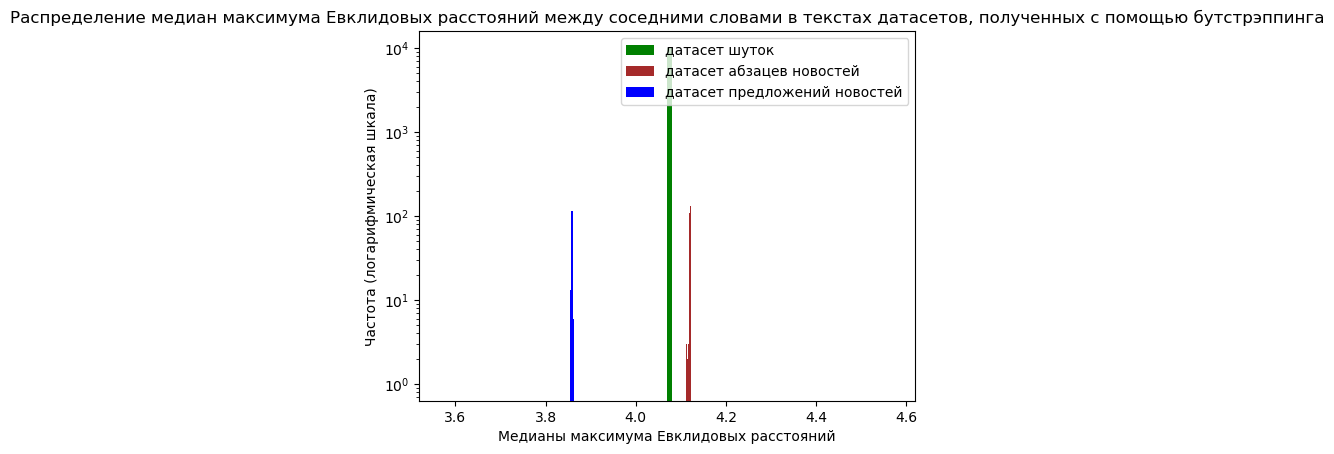

In [118]:
plt.hist(jokes_bootstrap_max_dist_mean, label='датасет шуток', bins=100, color='green')
plt.hist(news_paragraphs_bootstrap_max_dist_mean, label='датасет абзацев новостей', bins=100, color='brown')
plt.hist(news_sents_bootstrap_max_dist_mean, label='датасет предложений новостей', bins=100, color='blue')
plt.legend()
plt.yscale('log')

plt.title('Распределение медиан максимума Евклидовых расстояний между соседними словами в текстах датасетов, полученных с помощью бутстрэппинга')
plt.xlabel('Медианы максимума Евклидовых расстояний')
plt.ylabel('Частота (логарифмическая шкала)')

plt.show()

## Обратный эксперимент на перемешанных датасетах шуток и не шуток на основе векторов fasttext

### Перемешиваем в пропорции 1\:1:1 шутки:абзацы новостей:предложения новостей

In [86]:
shuffle_slice_df = pd.concat([jokes_slice_df, news_paragraphs_slice_df, news_sents_slice_df], axis=0)
shuffle_slice_df = shuffle_slice_df.sample(frac=1).reset_index(drop=True)
shuffle_slice_df_1 = shuffle_slice_df[:225522]
shuffle_slice_df_2 = shuffle_slice_df[225522:]

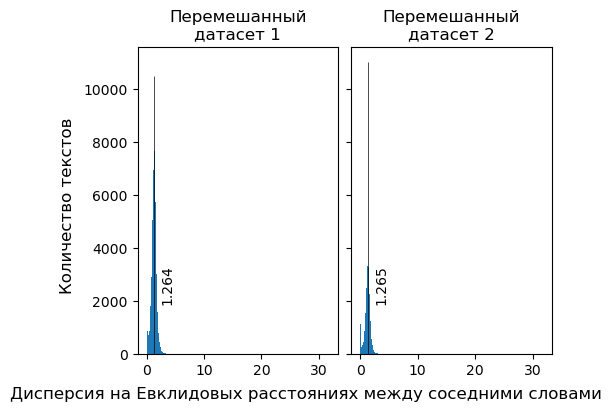

In [116]:
# Дисперсия

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all', constrained_layout=True, figsize=(5, 4))

ax1.hist(shuffle_slice_df_1['variation'], bins=1000)
ymin, ymax = ax1.get_ylim()
shuffle1_var_median = shuffle_slice_df_1['variation'].median()
ax1.vlines(x = shuffle1_var_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax1.text(2.4, 2000, str(round(shuffle1_var_median, 3)), color='black', rotation=90)
ax1.set_title('Перемешанный\nдатасет 1')

ax2.hist(shuffle_slice_df_2['variation'], bins=1000)
ymin, ymax = ax2.get_ylim()
shuffle2_var_median = shuffle_slice_df_2['variation'].median()
ax2.vlines(x = shuffle2_var_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax2.text(2.4, 2000, str(round(shuffle2_var_median, 3)), color='black', rotation=90)
ax2.set_title('Перемешанный\nдатасет 2')

fig.supxlabel('Дисперсия на Евклидовых расстояниях между соседними словами')
fig.supylabel('Количество текстов')

plt.show()

In [90]:
# Дисперсия

shuffle2_var = shuffle_slice_df_2.variation.values
shuffle1_var = shuffle_slice_df_1.variation.values

print("Тест Колмогорова-Смирнова на нормальность распределения. Отвергаемая нулевая гипотеза: что данные соответствуют нормальному распределению.")
print(f"Дисперсия перемешанного датасета 1, p-value={stats.kstest(shuffle1_var, 'norm')[1]}")
print(f"Дисперсия перемешанного датасета 1, p-value={stats.kstest(shuffle2_var, 'norm')[1]}")

print("\nНепараметрический критерий Вилкоксона")
print(f"- перемешанный датасет 1 vs. перемешанный датасет 2, p-value={wilcoxon(shuffle1_var, shuffle2_var)[1]}")

Тест Колмогорова-Смирнова на нормальность распределения. Отвергаемая нулевая гипотеза: что данные соответствуют нормальному распределению.
Дисперсия перемешанного корпуса 1, p-value=0.0
Дисперсия перемешанного корпуса 1, p-value=0.0

Непараметрический критерий Вилкоксона
- перемешанный корпус 1 vs. перемешанный корпус 2, p-value=0.6979866959876984


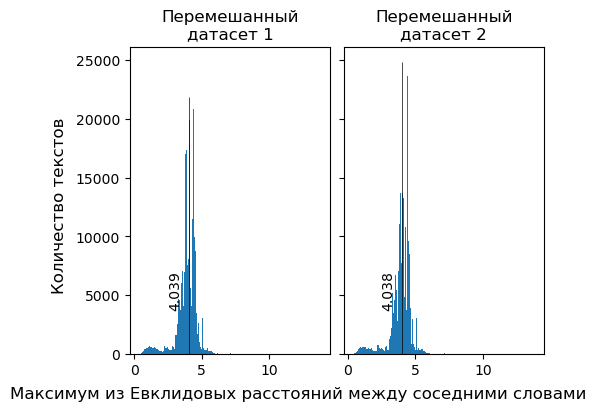

In [117]:
# Максимум

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all', constrained_layout=True, figsize=(5, 4))

ax1.hist(shuffle_slice_df_1['max_dist'], bins=200)
ymin, ymax = ax1.get_ylim()
shuffle1_max_dist_median = shuffle_slice_df_1['max_dist'].median()
ax1.vlines(x = shuffle1_max_dist_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax1.text(2.5, 4000, str(round(shuffle1_max_dist_median, 3)), color='black', rotation=90)
ax1.set_title('Перемешанный\nдатасет 1')

ax2.hist(shuffle_slice_df_2['max_dist'], bins=200)
ymin, ymax = ax2.get_ylim()
shuffle2_max_dist_median = shuffle_slice_df_2['max_dist'].median()
ax2.vlines(x = shuffle2_max_dist_median, ymin=ymin, ymax=ymax, color='black', lw=0.5)
ax2.text(2.5, 4000, str(round(shuffle2_max_dist_median, 3)), color='black', rotation=90)
ax2.set_title('Перемешанный\nдатасет 2')

fig.supxlabel('Максимум из Евклидовых расстояний между соседними словами')
fig.supylabel('Количество текстов')

plt.show()

In [95]:
# Максимум

shuffle1_max_dist = shuffle_slice_df_1.max_dist.values
shuffle2_max_dist = shuffle_slice_df_2.max_dist.values

print("Тест Колмогорова-Смирнова на нормальность распределения. Отвергаемая нулевая гипотеза: что данные соответствуют нормальному распределению.")
print(f"Максимум из Евклидовых расстояний перемешанного датасета 1, p-value={stats.kstest(shuffle1_max_dist, 'norm')[1]}")
print(f"Максимум из Евклидовых расстояний перемешанного датасета 1, p-value={stats.kstest(shuffle2_max_dist, 'norm')[1]}")

print("\nНепараметрический критерий Вилкоксона")
print(f"- перемешанный датасет 1 vs. перемешанный датасет 2, p-value={wilcoxon(shuffle1_max_dist, shuffle2_max_dist)[1]}")

Тест Колмогорова-Смирнова на нормальность распределения. Отвергаемая нулевая гипотеза: что данные соответствуют нормальному распределению.
Максимум из Евклидовых расстояний перемешанного корпуса 1, p-value=0.0
Максимум из Евклидовых расстояний перемешанного корпуса 1, p-value=0.0

Непараметрический критерий Вилкоксона
- перемешанный корпус 1 vs. перемешанный корпус 2, p-value=0.8098181502293045
